In [2]:
import pandas as pd
import sqlite3


def getSlotsFromDB(
    city: str, concern: str | None, office: str | None = None
) -> pd.DataFrame:

    conn = sqlite3.connect(f"db/{city}.db")

    sql = """
    SELECT 
        Availabilities.slot_id as s_id,
        Slots.office as office,
        Slots.city as city,
        Slots.timeslot as timeslot,
        Slots.concern as concern,
        Availabilities.id as a_id,
        Availabilities.available as available,
        Availabilities.taken as taken
    FROM Slots
    JOIN Availabilities ON Slots.id = Availabilities.slot_id;
    """

    df = pd.read_sql_query(sql, conn, parse_dates=["available", "taken", "timeslot"])

    conn.close()

    if concern:
        df = df[df["concern"] == concern]

    if office:
        df = df[df["office"] == office]

    return df


df = getSlotsFromDB(city="duesseldorf", concern="Personalausweis - Antrag")


In [3]:
def preprocess_dataframe(df):

    # add count of availabilities per s_id
    df["count_availabilities"] = df.groupby("s_id")["a_id"].transform("count")

    # lose precision to only minutes
    df["timeslot"] = df["timeslot"].dt.floor("min")
    df["available"] = df["available"].dt.floor("min")
    df["taken"] = df["taken"].dt.floor("min")

    # add weekday
    df["weekday"] = df["timeslot"].dt.day_name()

    # add hour
    df["hour"] = df["timeslot"].dt.hour

    # timedelta between available and taken
    df["delta"] = df["taken"] - df["available"]

    # time until slot
    df["time_until_slot"] = df["timeslot"] - df["available"]

    # add total delta per s_id
    df["total_delta"] = df.groupby("s_id")["delta"].transform("sum")

    # sort by total delta
    df = df.sort_values("time_until_slot", ascending=False)

    return df

df = preprocess_dataframe(df)

df

,s_id,office,city,timeslot,concern,a_id,available,taken,count_availabilities,weekday,hour,delta,time_until_slot,total_delta
90849,31317,Dienstleistungszentrum,Duesseldorf,2024-11-21 17:45:00,Personalausweis - Antrag,90850,2024-10-31 09:02:00,2024-10-31 15:20:00,5,Thursday,17,0 days 06:18:00,21 days 08:43:00,1 days 04:02:00
168333,52875,Dienstleistungszentrum,Duesseldorf,2024-11-28 17:45:00,Personalausweis - Antrag,168334,2024-11-07 09:03:00,NaT,1,Thursday,17,NaT,21 days 08:42:00,0 days 00:00:00
90848,31316,Dienstleistungszentrum,Duesseldorf,2024-11-21 17:40:00,Personalausweis - Antrag,90849,2024-10-31 09:02:00,2024-10-31 15:20:00,5,Thursday,17,0 days 06:18:00,21 days 08:38:00,1 days 04:02:00
168332,52874,Dienstleistungszentrum,Duesseldorf,2024-11-28 17:40:00,Personalausweis - Antrag,168333,2024-11-07 09:03:00,NaT,1,Thursday,17,NaT,21 days 08:37:00,0 days 00:00:00
90847,31315,Dienstleistungszentrum,Duesseldorf,2024-11-21 17:35:00,Personalausweis - Antrag,90848,2024-10-31 09:02:00,2024-10-31 15:20:00,5,Thursday,17,0 days 06:18:00,21 days 08:33:00,1 days 04:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50879,20866,Kaiserswerth,Duesseldorf,2024-10-30 07:55:00,Personalausweis - Antrag,50880,2024-10-30 07:52:00,2024-10-30 07:58:00,2,Wednesday,7,0 days 00:06:00,0 days 00:03:00,0 days 00:42:00
50820,21259,Wersten/Holthausen,Duesseldorf,2024-10-30 07:55:00,Personalausweis - Antrag,50821,2024-10-30 07:52:00,2024-10-30 07:58:00,2,Wednesday,7,0 days 00:06:00,0 days 00:03:00,0 days 00:29:00
23397,8919,Oberkassel,Duesseldorf,2024-10-28 09:10:00,Personalausweis - Antrag,23398,2024-10-28 09:07:00,2024-10-28 09:10:00,3,Monday,9,0 days 00:03:00,0 days 00:03:00,0 days 01:28:00
49802,21611,Eller,Duesseldorf,2024-10-30 07:30:00,Personalausweis - Antrag,49803,2024-10-30 07:28:00,2024-10-30 07:44:00,1,Wednesday,7,0 days 00:16:00,0 days 00:02:00,0 days 00:16:00


In [4]:
df.describe()

,s_id,timeslot,a_id,available,taken,count_availabilities,hour,delta,time_until_slot,total_delta
count,42451.000000,42451,42451.000000,42451,41143,42451.000000,42451.000000,41143,42451,42451
mean,21493.300770,2024-11-12 20:55:23.257402368,88533.252856,2024-11-01 10:14:33.178016768,2024-11-01 09:14:07.752473344,18.264564,10.943982,0 days 03:18:30.887392752,11 days 10:40:50.079385644,2 days 18:56:32.871310452
min,500.000000,2024-10-28 07:40:00,500.000000,2024-10-27 14:01:00,2024-10-27 14:03:00,1.000000,7.000000,0 days 00:01:00,0 days 00:02:00,0 days 00:00:00
25%,12164.000000,2024-11-05 12:35:00,52446.500000,2024-10-30 09:05:00,2024-10-30 10:48:00,2.000000,9.000000,0 days 00:04:00,1 days 06:30:00,0 days 03:11:00
50%,22438.000000,2024-11-15 09:50:00,84293.000000,2024-10-31 07:07:00,2024-10-31 06:08:00,6.000000,11.000000,0 days 00:38:00,14 days 22:26:00,1 days 04:24:00
75%,31063.000000,2024-11-19 13:50:00,124917.500000,2024-11-04 00:04:00,2024-11-03 23:21:00,36.000000,12.000000,0 days 03:59:00,18 days 15:41:00,6 days 04:51:00
max,54141.000000,2024-11-28 17:45:00,170805.000000,2024-11-07 09:57:00,2024-11-07 09:57:00,57.000000,17.000000,2 days 03:39:00,21 days 08:43:00,9 days 13:52:00
std,12796.715879,NaN,45167.490829,NaN,NaN,19.768158,2.439915,0 days 05:48:38.825408592,8 days 01:18:36.669509166,2 days 23:42:43.880461341


In [5]:
slots = df.groupby("s_id")[["hour", "weekday", "total_delta"]].first()
slots.sort_values("total_delta", ascending=False)

,hour,weekday,total_delta
s_id,,,
12203,13,Monday,9 days 13:52:00
12199,12,Monday,8 days 15:52:00
12188,11,Monday,8 days 15:07:00
19789,14,Tuesday,8 days 14:04:00
19788,14,Tuesday,8 days 14:04:00
...,...,...,...
52280,7,Monday,0 days 00:00:00
52279,7,Monday,0 days 00:00:00
52278,7,Friday,0 days 00:00:00


In [6]:
mean_delta_per_weekday = slots.groupby("weekday")["total_delta"].mean().dt.total_seconds() / 3600

<Axes: title={'center': "Durchschnittliche Zeit, die ein Termin 'buchbar' ist pro Wochentag des Termins"}, xlabel='Wochentag', ylabel='Stunden'>

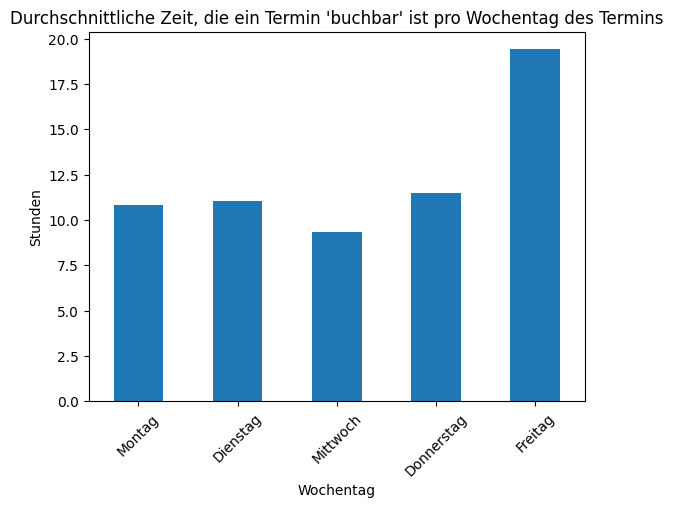

In [7]:
# Definieren Sie die richtige Reihenfolge der Wochentage
weekday_order = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag"]

# Wochentage in der DataFrame zu deutschen Wochentagen umbenennen
mean_delta_per_weekday.index = mean_delta_per_weekday.index.map({
	"Monday": "Montag",
	"Tuesday": "Dienstag",
	"Wednesday": "Mittwoch",
	"Thursday": "Donnerstag",
	"Friday": "Freitag",
})

# Stellen Sie sicher, dass die Wochentage in der richtigen Reihenfolge sind
mean_delta_per_weekday = mean_delta_per_weekday.reindex(weekday_order)

# Daten plotten
mean_delta_per_weekday.plot(kind="bar", title="Durchschnittliche Zeit, die ein Termin 'buchbar' ist pro Wochentag des Termins", ylabel="Stunden", xlabel="Wochentag", rot=45)

<Axes: title={'center': "Durchschnittliche Zeit, die ein Termin 'buchbar' ist abhängig davon, zu welcher Stunde der Termin ist"}, xlabel='Stunde', ylabel='Stunden'>

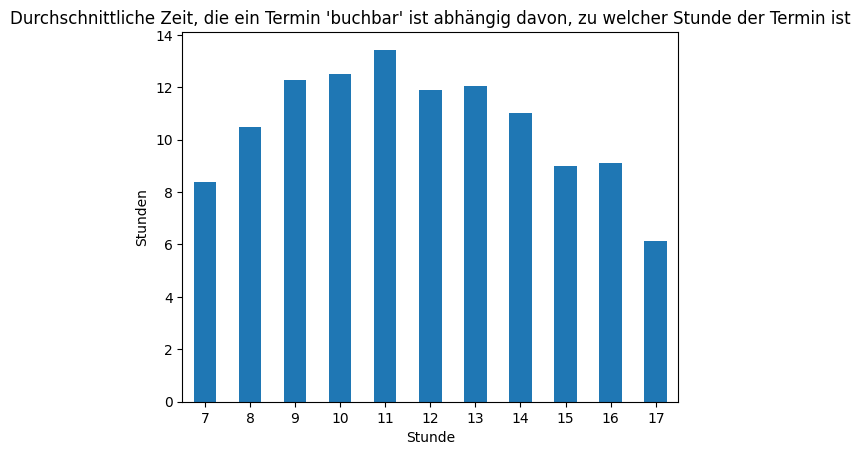

In [8]:
# plot the mean delta per hour
mean_delta_per_hour = slots.groupby("hour")["total_delta"].mean().dt.total_seconds() / 3600

mean_delta_per_hour.plot(kind="bar", title="Durchschnittliche Zeit, die ein Termin 'buchbar' ist abhängig davon, zu welcher Stunde der Termin ist", ylabel="Stunden", xlabel="Stunde", rot=0)

<Axes: title={'center': 'Verfügbare Termine über die Zeit'}, xlabel='Zeit', ylabel='Anzahl verfügbarer Termine'>

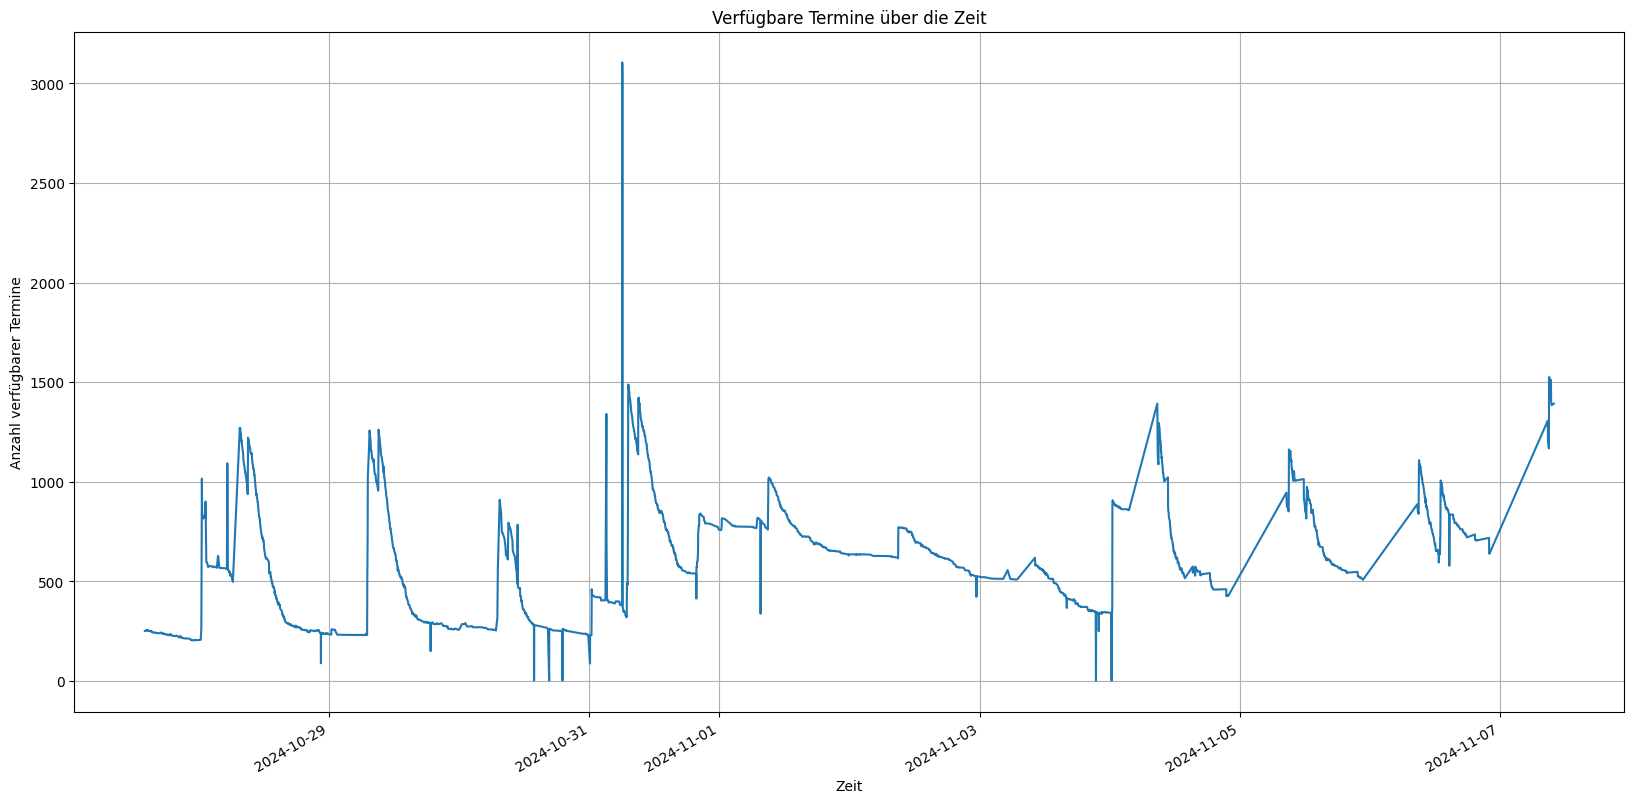

In [9]:
def count_per_timestamp(df):
    # get all unique timestamps from available and taken
    timestamps = pd.concat([df["available"], df["taken"]]).sort_values().unique()
    count = pd.Series(dtype=int)
    for timestamp in timestamps:
        # count slots for each timestamp
        count_per_timestamp = df[
            (df["available"] <= timestamp)
            & ((df["taken"] >= timestamp) | (df["taken"].isnull()))
        ].shape[0]
        count.at[timestamp] = count_per_timestamp
    return pd.DataFrame({"timestamp": timestamps, "count": count})

count_df = count_per_timestamp(df)

count_df.plot(
    x="timestamp",
    y="count",
    kind="line",
    figsize=(20, 10),
    grid=True,
    title="Verfügbare Termine über die Zeit",
    xlabel="Zeit",
    ylabel="Anzahl verfügbarer Termine",
    legend=False,
)

In [10]:
time_until_slot = df.groupby(by="available").agg({"timeslot": ["min", "max", "mean"]})

time_until_slot["time_until_slot_mean"] = (
    time_until_slot["timeslot"]["mean"] - time_until_slot.index
).dt.total_seconds() / 3600

time_until_slot["time_until_slot_min"] = (
    time_until_slot["timeslot"]["min"] - time_until_slot.index
).dt.total_seconds() / 3600

time_until_slot["time_until_slot_max"] = (
    time_until_slot["timeslot"]["max"] - time_until_slot.index
).dt.total_seconds() / 3600

time_until_slot

timeslot                      \
                                    min                 max   
available                                                     
2024-10-27 14:01:00 2024-10-28 12:40:00 2024-11-15 12:45:00   
2024-10-27 14:08:00 2024-11-11 10:35:00 2024-11-12 09:10:00   
2024-10-27 14:21:00 2024-11-11 08:45:00 2024-11-15 12:45:00   
2024-10-27 14:27:00 2024-11-11 08:45:00 2024-11-11 08:45:00   
2024-10-27 14:28:00 2024-10-28 14:30:00 2024-10-28 14:35:00   
...                                 ...                 ...   
2024-11-07 09:22:00 2024-11-07 10:55:00 2024-11-21 14:45:00   
2024-11-07 09:24:00 2024-11-07 10:15:00 2024-11-21 10:15:00   
2024-11-07 09:26:00 2024-11-12 12:40:00 2024-11-12 12:40:00   
2024-11-07 09:30:00 2024-11-07 10:50:00 2024-11-07 11:05:00   
2024-11-07 09:57:00 2024-11-07 10:05:00 2024-11-21 14:40:00   

                                                  time_until_slot_mean  \
                                             mean                        
available                                                                
2024-10-27 14:01:00 2024-11-13 21:42:55.200000000           415.698667   
2024-10-27 14:08:00 2024-11-11 16:17:30.000000000           362.158333   
2024-10-27 14:21:00 2024-11-13 22:19:39.841897216           415.977734   
2024-10-27 14:27:00 2024-11-11 08:45:00.000000000           354.300000   
2024-10-27 14:28:00 2024-10-28 14:32:30.000000000            24.075000   
...                                           ...                  ...   
2024-11-07 09:22:00 2024-11-13 12:51:43.571428608           147.495437   
2024-11-07 09:24:00 2024-11-13 05:47:51.428571392           140.397619   
2024-11-07 09:26:00 2024-11-12 12:40:00.000000000           123.233333   
2024-11-07 09:30:00 2024-11-07 10:57:30.000000000             1.458333   
2024-11-07 09:57:00 2024-11-13 22:20:54.545454592           156.398485   

                    time_until_slot_min time_until_slot_max  
                                                             
available                                                    
2024-10-27 14:01:00           22.650000          454.733333  
2024-10-27 14:08:00          356.450000          379.033333  
2024-10-27 14:21:00          354.400000          454.400000  
2024-10-27 14:27:00          354.300000          354.300000  
2024-10-27 14:28:00           24.033333           24.116667  
...                                 ...                 ...  
2024-11-07 09:22:00            1.550000          341.383333  
2024-11-07 09:24:00            0.850000          336.850000  
2024-11-07 09:26:00          123.233333          123.233333  
2024-11-07 09:30:00            1.333333            1.583333  
2024-11-07 09:57:00            0.133333          340.716667  

[1500 rows x 6 columns]

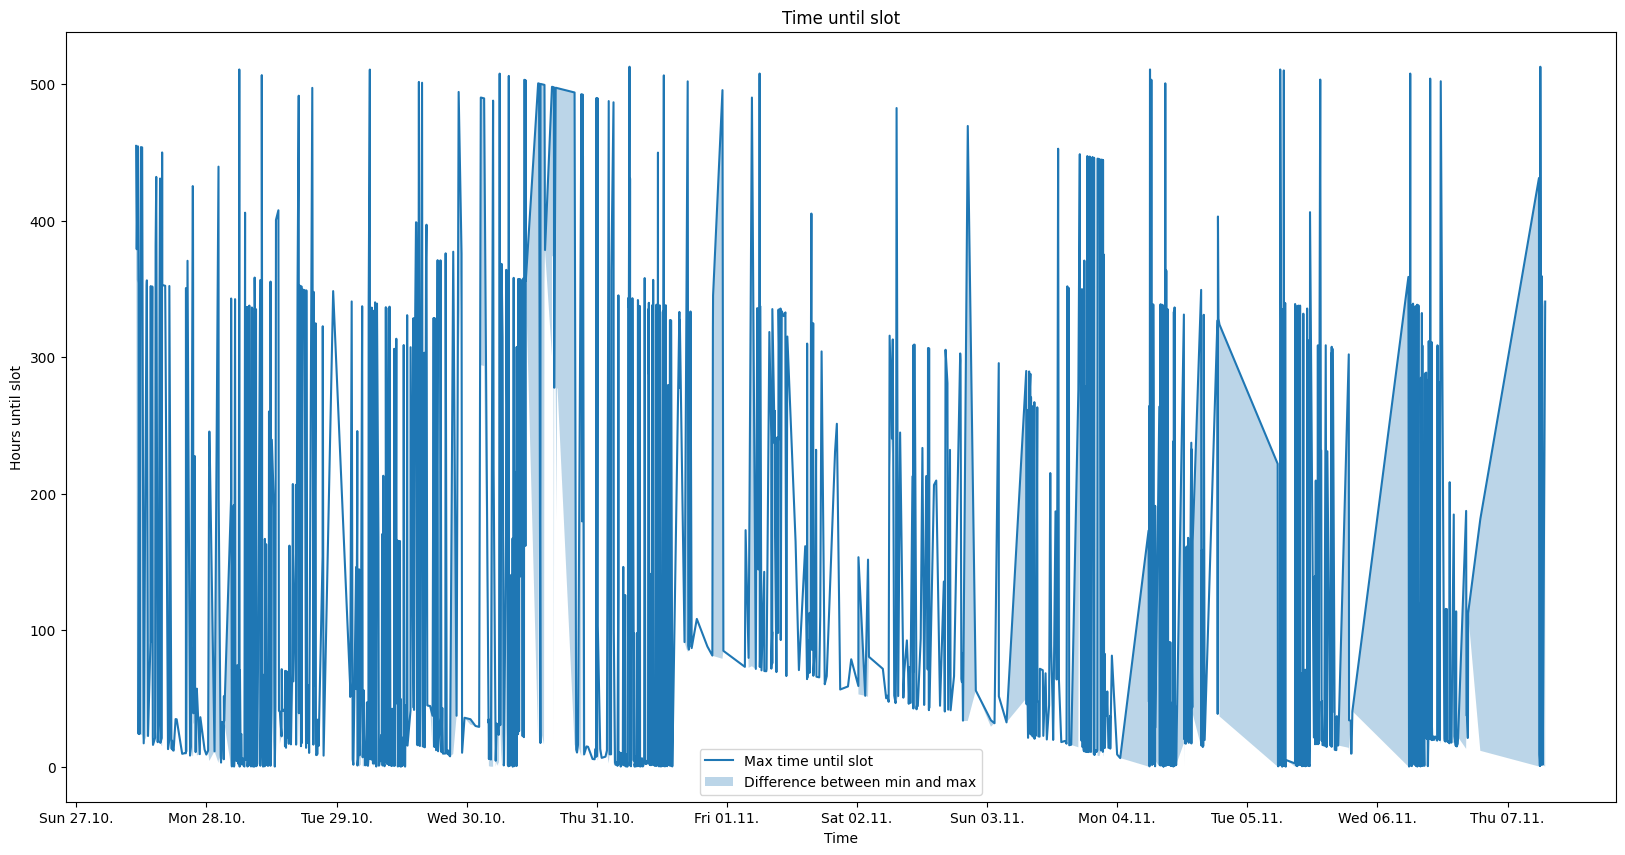

In [11]:
# convert to hours
# time_until_slot["h_until_slot"] = (
#     time_until_slot["time_until_slot"].dt.total_seconds() / 3600
# )
# time_until_slot["days_until_slot"] = time_until_slot["time_until_slot"].dt.days

# time_until_slot.plot(y="h_until_slot", kind="line",figsize=(20,10), grid=True, title="Time until slot", xlabel="Time", ylabel="Hours until slot")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(
#     time_until_slot.index,
#     time_until_slot["time_until_slot_mean"],
#     label="Mean time until slot",
# )
# ax.plot(
#     time_until_slot.index,
#     time_until_slot["time_until_slot_min"],
#     label="Min time until slot",
# )
ax.plot(
    time_until_slot.index,
    time_until_slot["time_until_slot_max"],
    label="Max time until slot",
)

# plot difference between min and max
ax.fill_between(
    time_until_slot.index,
    time_until_slot["time_until_slot_min"],
    time_until_slot["time_until_slot_max"],
    alpha=0.3,
    label="Difference between min and max",
)

# ax.scatter(
#     time_until_slot.index,
#     time_until_slot["h_until_slot"],
#     label="Hours until slot",
# )

ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m."))

ax.set_title("Time until slot")
ax.set_xlabel("Time")
ax.set_ylabel("Hours until slot")
ax.legend()

plt.show()

/tmp/ipykernel_261555/3376927379.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_until_slot_filled = time_until_slot.resample("T").ffill()


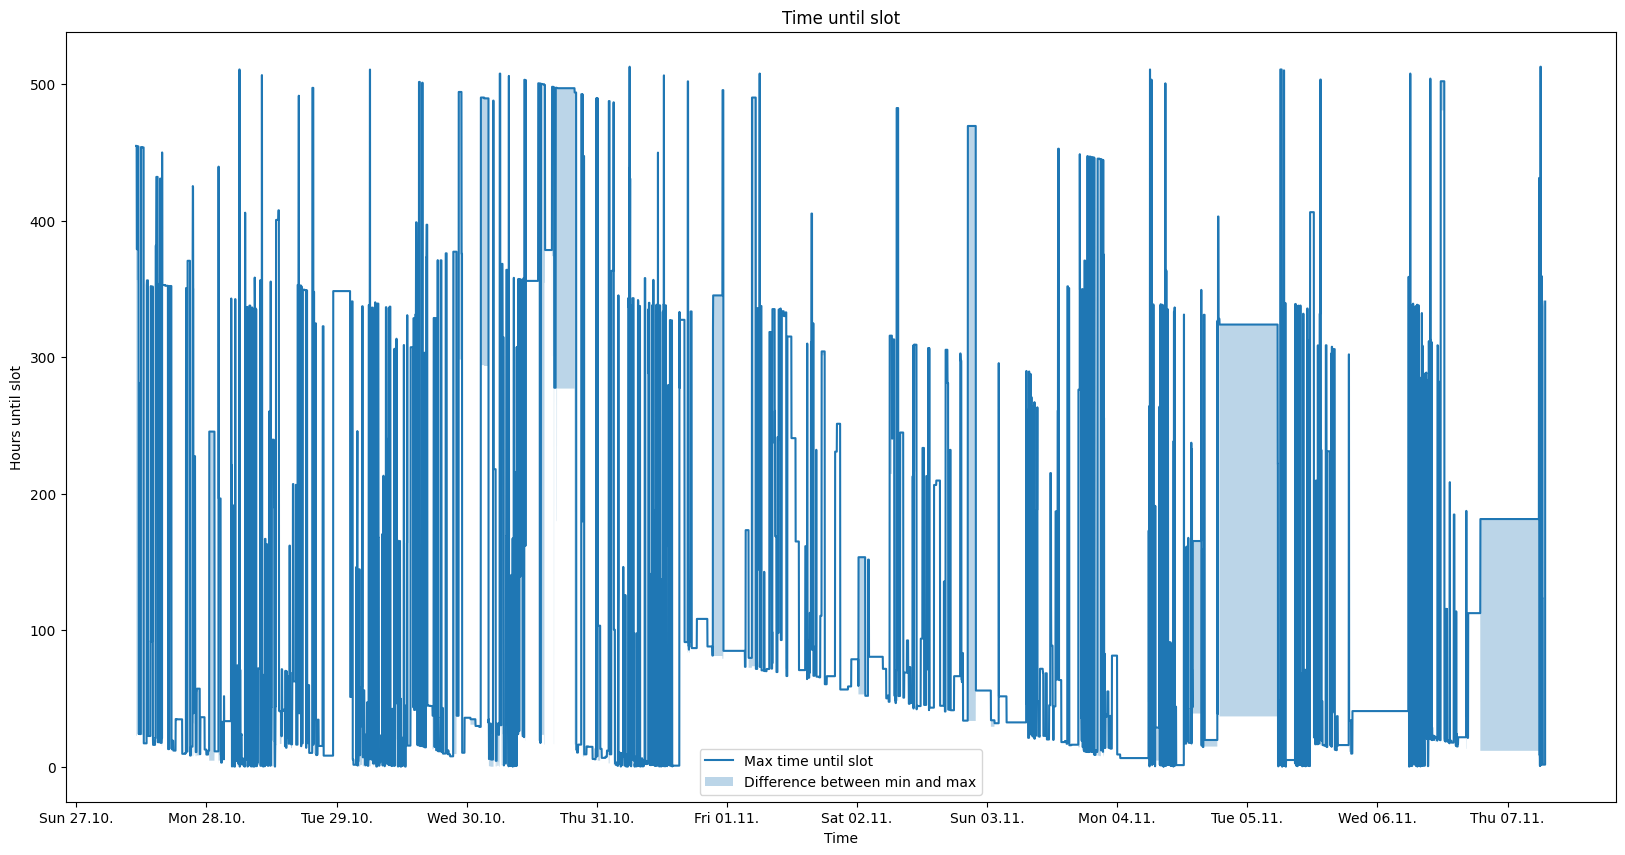

In [13]:
# fill every minute between the timestamps with the last value in time_until_slot dataframe
time_until_slot_filled = time_until_slot.resample("T").ffill()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(
    time_until_slot_filled.index,
    time_until_slot_filled["time_until_slot_max"],
    label="Max time until slot",
)

ax.fill_between(
    time_until_slot_filled.index,
    time_until_slot_filled["time_until_slot_min"],
    time_until_slot_filled["time_until_slot_max"],
    alpha=0.3,
    label="Difference between min and max",
)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%m."))


ax.set_title("Time until slot")
ax.set_xlabel("Time")
ax.set_ylabel("Hours until slot")
ax.legend()

plt.show()

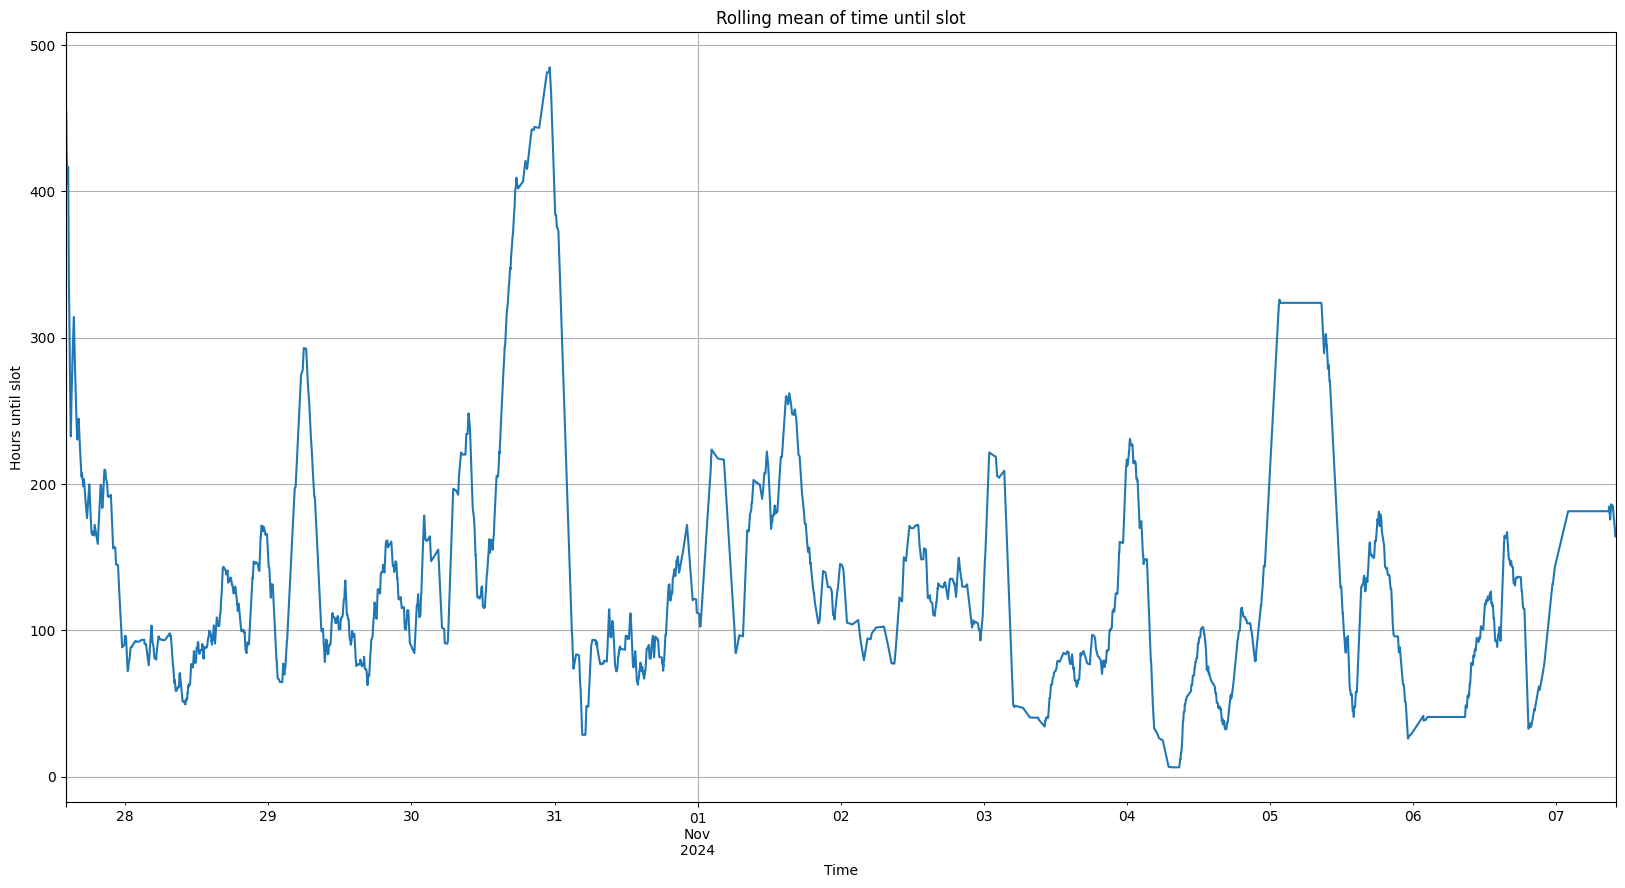

In [ ]:
# plot rolling mean of time until slot for 6 hours

time_until_slot_filled["time_until_slot_max"].rolling("4h").mean().plot(
    figsize=(20, 10), grid=True, title="Rolling mean of time until slot", xlabel="Time", ylabel="Hours until slot"
)

plt.show()